# NLP Document Comparison (2008 Financial Crisis)

##### Objective: Compare a fed conference call transcript from Sept. 29th, 2008 with a CNN article from the same day.
- [Emotion Analysis](#emotion-analysis)
- [Word Cloud](#word-cloud)
- [LDA Topic Modeling](#topic-modeling)
- [Sentiment Analysis](#sentiment-analysis)
- [Document Summary](#summary)
- [Document Similarity](#similarity)

#### Install required libraries

In [ ]:
pip install spacy nltk gensim PyPDF2 NRClex pyLDAvis selenium webdriver_manager wordcloud sumy transformers torch

In [ ]:
!python -m spacy download en_core_web_sm

In [4]:
import re
import pandas as pd
import spacy
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from PyPDF2 import PdfReader
from nltk.tokenize import sent_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from collections import Counter
from nrclex import NRCLex
from gensim import corpora
import gensim
from nltk.stem import WordNetLemmatizer
from gensim import corpora
from gensim.models import LdaModel
import plotly.graph_objects as go
import plotly.express as px
import re
from textblob import TextBlob
import PyPDF2
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
import en_core_web_sm

#### Data collection from PDF files and CNN web page

In [5]:
reader = PdfReader('FOMC20080929confcall.pdf')
transcript_text = []
for page in reader.pages:
    transcript_text.append(page.extract_text())
full_fed_text = ' '.join(transcript_text)
clean_fed_text = full_fed_text.replace('\n', ' ').replace('\r', '')
fed_sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', clean_fed_text)
df_fed = pd.DataFrame(fed_sentences)
df_fed = df_fed.rename(columns={0: 'sentences'})

In [9]:
chrome_options = Options()
chrome_options.add_argument("--headless")  # Ensure GUI is off
chrome_options.add_argument("--no-sandbox")  # Bypass OS security model
chrome_options.add_argument("--disable-dev-shm-usage")  # Overcome limited resource problems
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=chrome_options)

url = "https://money.cnn.com/2008/09/29/markets/markets_newyork/"

driver.get(url)

article_content = driver.find_element(By.CLASS_NAME, "storytext")

article_text = article_content.text if article_content else "No article content found."

driver.quit()

clean_cnn_text = article_text.replace('\n', ' ').replace('\r', '')
cnn_sentences = sent_tokenize(clean_cnn_text)
df_cnn = pd.DataFrame(cnn_sentences)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

#### Emotion Analysis <a class="anchor" id="emotion-analysis"></a>

In [37]:
def get_emotion_scores(text):
    emotion = NRCLex(text)
    return emotion.raw_emotion_scores

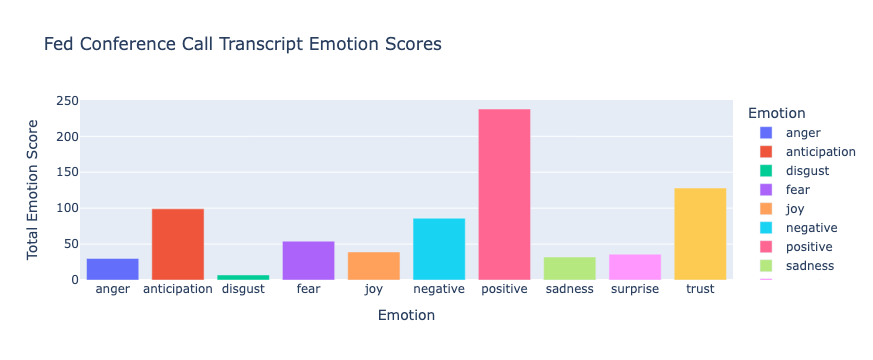

In [38]:
df_fed['emotion_scores'] = df_fed['sentences'].apply(get_emotion_scores)
emotions_df = df_fed['emotion_scores'].apply(pd.Series).fillna(0)
result_df = pd.concat([df_fed.drop(columns=['emotion_scores']), emotions_df], axis=1)
melted_df = result_df.melt(id_vars=['sentences'], var_name='emotion', value_name='score')
total_scores = melted_df.groupby('emotion')['score'].sum().reset_index()

fed_emotion = px.bar(total_scores, x='emotion', y='score', color='emotion',
             labels={'score': 'Total Emotion Score', 'emotion': 'Emotion'},
             title='Fed Conference Call Transcript Emotion Scores')

fed_emotion.update_layout(
    xaxis_title='Emotion',
    yaxis_title='Total Emotion Score',
)

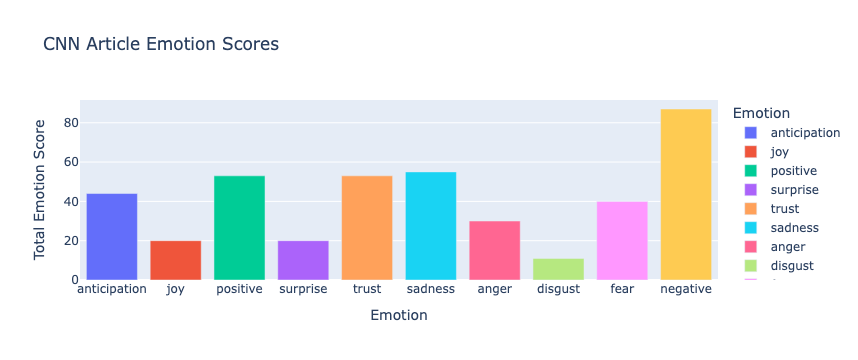

In [39]:
scores_list = []
for sentence in sentences:
    emotion = NRCLex(sentence)
    scores = emotion.raw_emotion_scores
    scores_list.append(scores)

melted_df = pd.DataFrame(scores_list)

total_scores = melted_df.sum().reset_index()
total_scores.columns = ['emotion', 'score']

cnn_emotion = px.bar(total_scores, x='emotion', y='score', color='emotion',
             labels={'score': 'Total Emotion Score', 'emotion': 'Emotion'},
             title='CNN Article Emotion Scores')

cnn_emotion.update_layout(
    xaxis_title='Emotion',
    yaxis_title='Total Emotion Score',
)

#### Word Cloud <a class="anchor" id="word-cloud"></a> 

In [40]:
from wordcloud import WordCloud

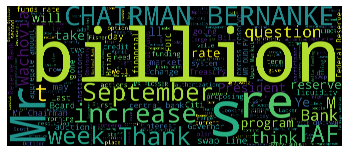

In [44]:
wc_fed = WordCloud(width = 12000, height = 5000,
                  stopwords=['s','re','t','Mr']).generate(clean_fed_text)
plt.axis("off")
plt.imshow(wc_fed)

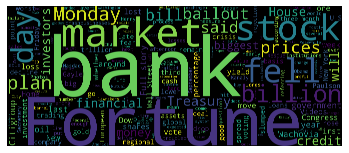

In [45]:
wc_cnn = WordCloud(width = 12000, height = 5000).generate(clean_cnn_text)
plt.axis("off")
plt.imshow(wc_cnn)

#### LDA Topic Modeling <a class="anchor" id="topic-modeling"></a> 

In [ ]:
import spacy
spacy.load('en')
from spacy.lang.en import English
parser = English()
def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

#### Sentiment analysis with nltk VADER <a class="anchor" id="sentiment-analysis"></a> 

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/isaiaherb/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [141]:
confcalldict = {
    'text': [],
    'compound': []}
sia = SentimentIntensityAnalyzer()
for sentence in sentences:
    confcalldict['text'].append(sentence)    
    confcalldict['compound'].append(sia.polarity_scores(sentence)['compound'])
df = pd.DataFrame(confcalldict)
print(df['compound'].describe())

count    378.000000
mean       0.138593
std        0.297013
min       -0.843900
25%        0.000000
50%        0.000000
75%        0.361200
max        0.975000
Name: compound, dtype: float64


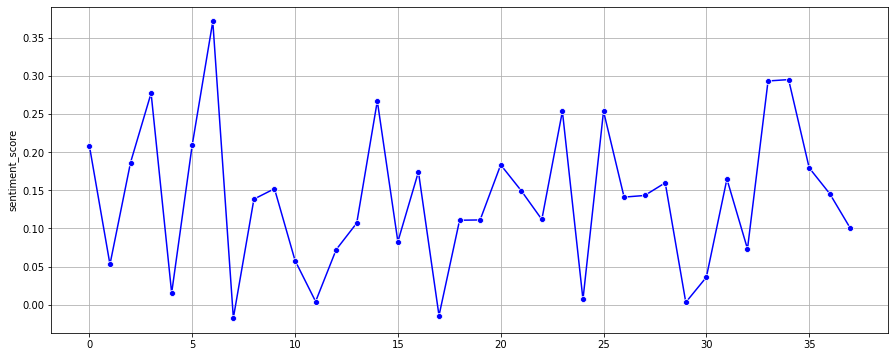

In [142]:
window_size = 10
moving_averages = [df['compound'].iloc[i:i+window_size].mean() for i in range(0, len(df), window_size)]

result_df = pd.DataFrame({
    'sentiment_score': moving_averages
})
plt.figure(figsize = (15,6))
sns.lineplot(data=result_df['sentiment_score'], marker='o', linestyle='-', color='b')
plt.grid(True)
plt.show()

In [ ]:
s = {
    'text': [],
    'compound': []}
sia = SentimentIntensityAnalyzer()
for sentence in sentences:
    confcalldict['text'].append(sentence)    
    confcalldict['compound'].append(sia.polarity_scores(sentence)['compound'])
df = pd.DataFrame(confcalldict)
print(df['compound'].describe())

In [ ]:
window_size = 10
moving_averages = [df['compound'].iloc[i:i+window_size].mean() for i in range(0, len(df), window_size)]

result_df = pd.DataFrame({
    'sentiment_score': moving_averages
})
plt.figure(figsize = (15,6))
sns.lineplot(data=result_df['sentiment_score'], marker='o', linestyle='-', color='b')
plt.grid(True)
plt.show()

#### Summarizing documents with Google Vertex <a class="anchor" id="summary"></a> 

In [6]:
from transformers import pipeline

def abstractive_summary(text, max_length=50, min_length=25):
    summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
    try:
        if len(text) < min_length:
            raise ValueError("Input text is too short for summarization")
        
        summary = summarizer(text, max_length=max_length, min_length=min_length, do_sample=False)
        
        if not summary or len(summary) == 0:
            raise ValueError("Summarizer returned an empty result")
        
        return summary[0]['summary_text']
    except Exception as e:
        print(f"Error during summarization: {e}")
        return None

In [14]:
abstractive_summary(clean_fed_text)

Token indices sequence length is longer than the specified maximum sequence length for this model (8296 > 1024). Running this sequence through the model will result in indexing errors


Error during summarization: index out of range in self


In [13]:
abstractive_summary(clean_cnn_text)

Token indices sequence length is longer than the specified maximum sequence length for this model (2277 > 1024). Running this sequence through the model will result in indexing errors


Error during summarization: index out of range in self


#### Document similarity scores using spaCy <a class="anchor" id="similarity"></a> 

In [10]:
nlp = spacy.load("en_core_web_sm")
nlp = en_core_web_sm.load()

In [12]:
doc1 = nlp(clean_fed_text)
doc2 = nlp(clean_cnn_text)
print(doc1.similarity(doc2))

0.7852835260566082


/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/ipykernel_45550/4207276934.py:3: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  print(doc1.similarity(doc2))
